In [1]:
from abc import ABC, abstractmethod
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

from gpytorch.optim import NGD
from gpytorch.mlls import VariationalELBO
from gpytorch.models import ApproximateGP
from torch.optim import Adam
from torch.nn import Parameter
from torch.nn import Module
from gpytorch.constraints import Positive, Interval

In [2]:
# TODO possibly make MultitaskGP an approximate GP 

class MultitaskGP(gpytorch.models.ExactGP):
    """ 
    Multitask GP model class.
    Used for multitask GP regression on latent functions
    in the latent force model.

    Args:
        X (torch.Tensor): training data (time points)
        y (torch.Tensor): target data (latent forces)
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module
    """
    def __init__(self,
                 X : torch.Tensor,
                 y : torch.Tensor,
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel):
        
        super(MultitaskGP, self).__init__(train_inputs=X,
                                          train_targets=y,
                                          likelihood=gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y.shape[1]))
        self.X = X
        self.mean_module = mean_module
        self.covar_module = covar_module
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y.shape[1])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    def predict(self, x):
        self.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            
            predictions = self.likelihood(self(x))
           
            mean = predictions.mean
            lower, upper = predictions.confidence_region()
            return mean, lower, upper
    
    def get_latents(self, x):
        self.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            return self.likelihood(self(x))

    def fit(self,
            n_iter : int,
            lr : float,
            optim : torch.optim.Optimizer,
            device : torch.device,
            verbose : bool = True):
        
        self.train()
        self.likelihood.train()
        
        self.to(device)
        self.likelihood.to(device)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        optimizer = optim(self.parameters(), lr=lr)
        
        print_freq = n_iter // 10

        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.X)
            loss = -mll(output, self.train_targets)
            loss.backward()
            optimizer.step()

            if (i+1) % print_freq == 0 and verbose:
                print(f'Iter {i+1} - Loss: {loss.item()}')


In [3]:
from src.data_loader import PVDataLoader
from src import data_loader as dl

In [4]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

In [5]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
y = y[:, IDX].unsqueeze(-1)
x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)

==> Loading data
==> Loaded data in: 0 m : 7 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [6]:
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, minute_interval=MINUTE_INTERVAL).unsqueeze(-1)
periodic_train, _, periodic_test, _ = dl.train_test_split(periodic_time, y, n_hours=N_HOURS_PRED)
x = torch.arange(0, len(periodic_time)).unsqueeze(-1).float()

In [282]:
# x = torch.linspace(0, torch.pi, 100)
# y = torch.stack([torch.sin(x * 2 * torch.pi) + torch.randn(x.size(0)) * 0.2,
#                 #  x*torch.cos(x * 2 * torch.pi) + torch.randn(x.size(0)) * 0.2,
#                 #  (x-3/2)**3  +  torch.randn(x.size(0)) * 0.2,
#                 #  -x + torch.randn(x.size(0))*0.2,
#                 ], -1)


# # generate random weights from a normal distribution
# w = torch.randn(y.size(1), 1)
# z = y @ w + torch.randn(y.size(0), 1) * 0.1

# z_train, z_test = z[:75], z[75:]

In [19]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y.shape[1])
mean_module = gpytorch.means.MultitaskMean(
                    gpytorch.means.ConstantMean(),
                    num_tasks=y.shape[1]
                )
covar_module = gpytorch.kernels.MultitaskKernel(
                    gpytorch.kernels.RBFKernel(),
                    num_tasks=y.shape[1],
                    rank=1
                )
multitask_model = MultitaskGP(X=x,
                              y=periodic_time, 
                              mean_module=mean_module, 
                              covar_module=covar_module)
multitask_model.fit(n_iter=100, 
                    lr=0.1, 
                    optim=Adam, 
                    device=torch.device('cpu'), 
                    verbose=True)

Iter 10 - Loss: 0.931654691696167
Iter 20 - Loss: 0.4808979034423828
Iter 30 - Loss: -0.01259002648293972
Iter 40 - Loss: -0.4876651167869568
Iter 50 - Loss: -0.9802366495132446
Iter 60 - Loss: -1.4628132581710815
Iter 70 - Loss: -1.9040255546569824
Iter 80 - Loss: -2.252009630203247
Iter 90 - Loss: -2.470292329788208
Iter 100 - Loss: -2.581423759460449


In [30]:
def plot_multitask_gp(multitask_model, x, lfs, target):
    lfs_pred, lower, upper = multitask_model.predict(x)
    if len(x.shape) > 1:
        x = x.squeeze(-1)

    # create color array of length 10
    colors = plt.get_cmap('tab10').colors

    plt.rcParams['font.family'] = 'Arial'

    plt.figure(figsize=(12, 6))
    # plot each task
    for i in range(lfs.shape[1]):
        plt.plot(x.numpy(), lfs[:, i].numpy(), 'o', color=colors[i], fillstyle='none')
        plt.plot(x.numpy(), lfs_pred[:, i].numpy(), color=colors[i], label=f'Latent Force {i+1}')
        plt.fill_between(x.numpy(), lower[:, i].numpy(), upper[:, i].numpy(), color=colors[i], alpha=0.2)
    
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('Latent Force', fontsize=13)

    plt.plot(x.numpy(), target.numpy(), 'o', color='black', label='Target', fillstyle='none')
    
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


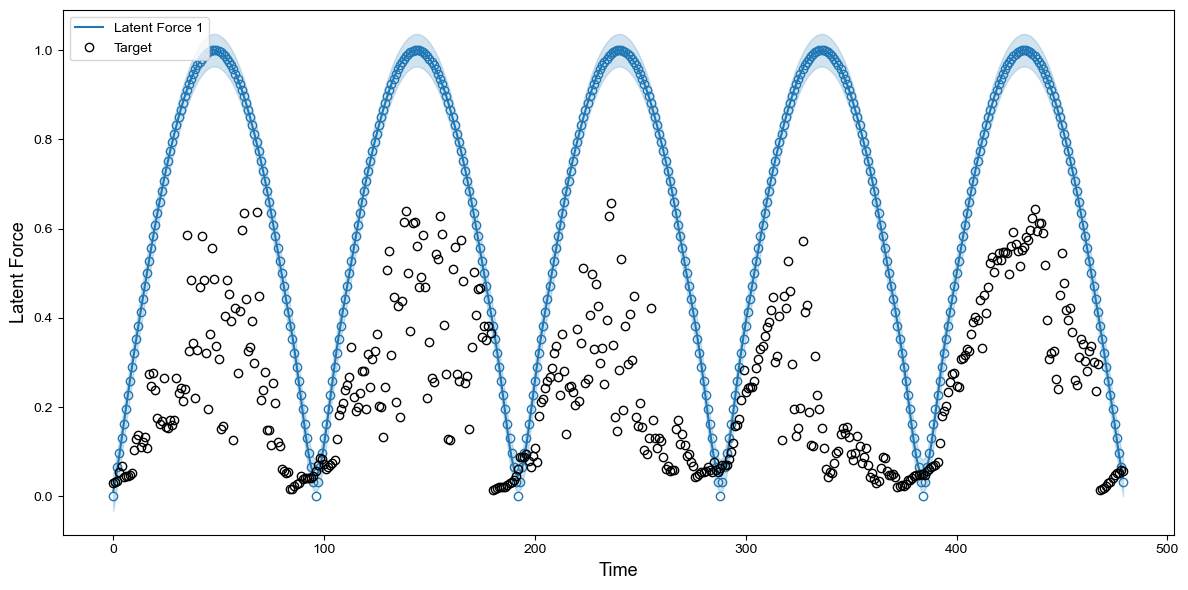

In [31]:
plot_multitask_gp(multitask_model, x=x, lfs=periodic_time, target=y)

In [12]:
from torchdiffeq import odeint

class LFMBase(Module):
    pass

class OrdinaryLFM(LFMBase, ABC):
    def __init__(self, 
                 X : torch.Tensor,
                 y : torch.Tensor,
                 gp_model : MultitaskGP,
                 num_outputs : int,
                 num_samples : int = 30,
                 **kwargs):
        
        super(OrdinaryLFM, self).__init__()
        
        self.X = X
        self.y = y
        self.gp_model = gp_model
        self.num_outputs = num_outputs
        self.num_samples = num_samples
        
        # TODO discuss how this will be with 
        # training vs testing data as we have 
        # test data for the latent forces 
        self.generate_latent_posteriors()
        
    def generate_latent_posteriors(self):
        # fit GP on latent data to get latent forces
        self.gp_model.fit(  n_iter=100,
                            lr=0.1,
                            optim=Adam,
                            device=torch.device('cpu'),
                            verbose=False)
        
    @abstractmethod
    def odefunc(self, t, x, **kwargs):
        """ 
        Define the ODE system to be solved
        
        Args:
            t (torch.Tensor): time
            x (torch.Tensor): latent forces
        """
        pass

    def forward(self, t, step_size=1, **kwargs):
        """ 
        Use the latent forces to make predictions on the ODE system
        for our target outputs
        """
        q_u = self.gp_model.get_latents(t)
        
        # f shape is (num_samples, time_points, n_latent_forces)
        q = q_u.rsample(torch.Size([self.num_samples]))
        
        y0 = self.y[0]
        h_samples = odeint(self.odefunc, y0, t, method='rk4' , options=dict(step_size=x[1] - x[0]))

        return self.build_target_dist(t, h_samples)
    
    def build_target_dist(self, t, h_samples):
        """
        Build a distribution for the target outputs
        """
        h_mean = h_samples.mean(dim=1)
        h_var = h_samples.var(dim=1) 

        return gpytorch.distributions.MultivariateNormal(h_mean, h_var)

        # build a beta likelihood GP for the target output


In [13]:
class PeriodicODE(OrdinaryLFM, ApproximateGP):
    """
    LFM Model where outputs are PV output
    and latents are weather variables
    """
    def __init__(self, X, y, num_outputs, gp_model, **kwargs):
        super(PeriodicODE, self).__init__(X, y, gp_model, num_outputs, **kwargs)
        # TODO add relevant constraints to the parameters
        self.beta = Parameter(torch.randn(X.shape[1] - 1, 1))
        self.alpha = Parameter(torch.randn(1, 1))
        # TODO add variational configuration for target distribution
    
    @property
    def initial_pv(self):
        return self.y[0]
    
    @initial_pv.setter
    def initial_pv(self, value):
        self.y[0] = value
    
    def odefunc(self, t, h, **kwargs):
        """
        Define the ODE system of linear operators on PV output
        from the latent forces (weather variables)

        Args:
            t (torch.Tensor): time
            x (torch.Tensor): latent forces
        """
        # TODO handle initial state
        # TODO handle time step
        # TODO handle latent forces (weather variables)
        
        dhdt = (self.beta @ self.f[:,:,:-1]  - self.alpha  + self.f[:,:,-1:] ) * h

        return dhdt
    
    def fit(self, n_iter, lr, optim, device, verbose=True):
        """
        Fit the ODE system using the latent forces
        """
        self.to(device)
        optimizer = optim(self.parameters(), lr=lr)
        elbo = gpytorch.mlls.VariationalELBO(self.likelihood, self, num_data=self.y.size(0))
        
        print_freq = n_iter // 10
        self.losses = []
        
        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.X)
            loss = -elbo(output, self.y)
            loss.backward()
            optimizer.step()

            self.losses.append(loss.item())

            if verbose and (i+1) % print_freq == 0:
                print(f'Iter {i+1}/{n_iter} - Loss: {loss.item():.3f}')
